<a href="https://colab.research.google.com/github/Vinayyarakalapudi/miniproject/blob/main/price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("hello")

hello


In [2]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
!git clone https://github.com/Vinayyarakalapudi/miniproject.git

Cloning into 'miniproject'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 59.24 KiB | 866.00 KiB/s, done.
Resolving deltas: 100% (6/6), done.


In [6]:
df = pd.read_csv("miniproject/crop_price_dataset.csv")
df.head()

,month,commodity_name,avg_modal_price,avg_min_price,avg_max_price,state_name,district_name,calculationType,change
0,2025-03-01,Maize,2341.58,2191.23,2402.98,India,All,Monthly,-14.43
1,2025-02-01,Maize,2356.01,2202.35,2414.46,India,All,Monthly,-26.19
2,2025-01-01,Maize,2382.20,2221.31,2448.22,India,All,Monthly,53.42
3,2024-12-01,Maize,2328.78,2164.86,2411.66,India,All,Monthly,55.32
4,2024-11-01,Maize,2273.46,2077.63,2377.78,India,All,Monthly,35.48


In [8]:
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values('month')
df.head()

,month,commodity_name,avg_modal_price,avg_min_price,avg_max_price,state_name,district_name,calculationType,change
2809,2010-01-01,Coconut,3169.00,2773.97,3562.30,India,All,Monthly,NaN
914,2010-01-01,Cotton,3172.90,2946.80,3257.02,India,All,Monthly,NaN
1097,2010-01-01,Coffee,8079.17,7912.50,8233.33,India,All,Monthly,NaN
548,2010-01-01,Rice,1874.00,1760.76,2077.57,India,All,Monthly,NaN
2626,2010-01-01,Groundnut,2666.46,2395.57,2841.78,India,All,Monthly,NaN


In [9]:
df = df[df['commodity_name'] == "Maize"]

In [10]:
df['Month_Number'] = df['month'].dt.month
df['Year'] = df['month'].dt.year

df['Lag1'] = df['avg_modal_price'].shift(1)
df['Lag2'] = df['avg_modal_price'].shift(2)
df['Lag3'] = df['avg_modal_price'].shift(3)

df['Rolling_Mean_3'] = df['avg_modal_price'].rolling(3).mean()
df['Rolling_Mean_6'] = df['avg_modal_price'].rolling(6).mean()

df['Rolling_Std_3'] = df['avg_modal_price'].rolling(3).std()

df['Change_Lag1'] = df['change'].shift(1)

df = df.dropna()

In [11]:
features = [
    'Month_Number',
    'Year',
    'Lag1',
    'Lag2',
    'Lag3',
    'Rolling_Mean_3',
    'Rolling_Mean_6',
    'Rolling_Std_3',
    'Change_Lag1'
]

X = df[features]
y = df['avg_modal_price']

In [12]:
from sklearn.model_selection import TimeSeriesSplit

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 800],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

pred = best_model.predict(X)

rmse = np.sqrt(mean_squared_error(y, pred))
mae = mean_absolute_error(y, pred)
r2 = r2_score(y, pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 20.298050359405245
MAE: 14.24192851123595
R2 Score: 0.9972159584972066


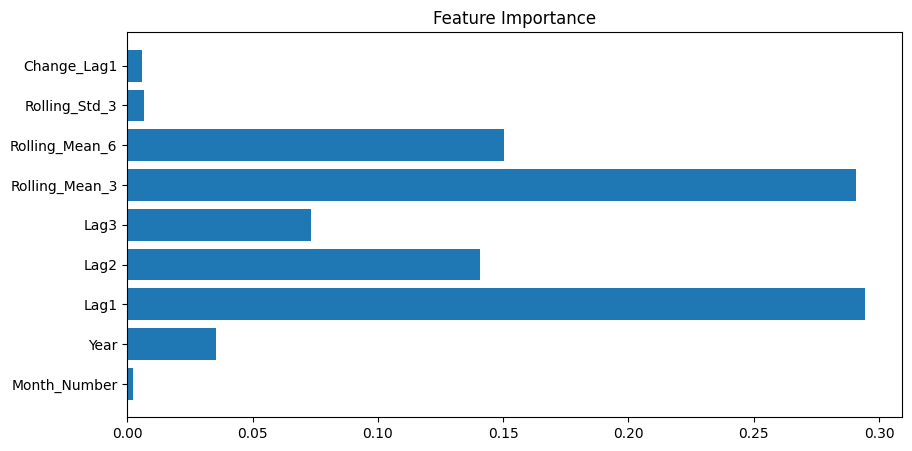

In [16]:
import matplotlib.pyplot as plt

importance = best_model.feature_importances_

plt.figure(figsize=(10,5))
plt.barh(features, importance)
plt.title("Feature Importance")
plt.show()

In [17]:
last_row = X.iloc[-1].values.tolist()

future_prices = []

for i in range(6):
    prediction = best_model.predict([last_row])[0]
    future_prices.append(prediction)

    last_row[4] = last_row[3]
    last_row[3] = last_row[2]
    last_row[2] = prediction

future_prices

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[np.float64(2328.18271250001),
 np.float64(2326.8238500000084),
 np.float64(2327.4848875000084),
 np.float64(2333.1971750000102),
 np.float64(2333.2652500000104),
 np.float64(2333.1129250000104)]

In [18]:
slope = np.polyfit(range(len(future_prices)), future_prices, 1)[0]

if slope > 0:
    trend = "Upward 📈"
elif slope < 0:
    trend = "Downward 📉"
else:
    trend = "Stable ➖"

print("Predicted Trend:", trend)

Predicted Trend: Upward 📈


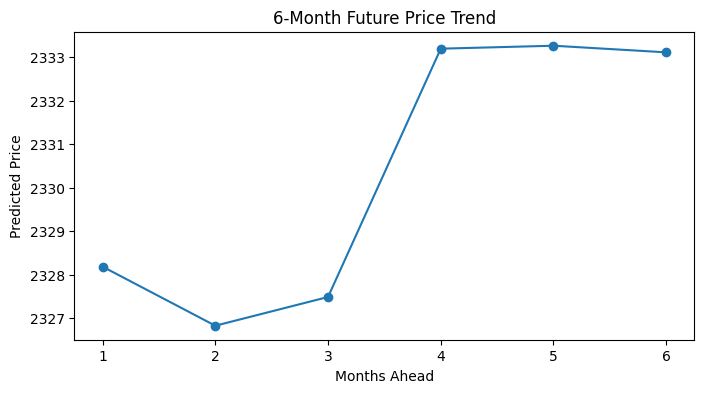

In [19]:
plt.figure(figsize=(8,4))
plt.plot(range(1,7), future_prices, marker='o')
plt.title("6-Month Future Price Trend")
plt.xlabel("Months Ahead")
plt.ylabel("Predicted Price")
plt.show()

In [20]:
import pickle
pickle.dump(best_model, open("rf_trend_model.pkl", "wb"))